# Aprendizaje por refuerzo profundo - Libreta 5
*por Roberto-Esteban López-Díaz*


Obetivos de esta libreta:
- Métodos de aprendizaje libre de modelo:
- Métodos Monte-Carlo
- Métodos Diferencia-Temporal

In [1]:
# Ejecutar una vez
!pip install gif
!git clone https://github.com/Bobobert/RL_Toy
!pip install /content/RL_Toy/

  Created wheel for gif: filename=gif-3.0.0-cp37-none-any.whl size=4817 sha256=22b9f0cba1de1764c79235965ad4e4f21d546020cb8c36f98e0701dbacda7fc8
  Stored in directory: /root/.cache/pip/wheels/33/1a/03/e7ccc13d5cbed82b0fda53a7792dfe372cf8baf691601d78d1
Successfully built gif
Cloning into 'RL_Toy'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 275 (delta 137), reused 176 (delta 39), pack-reused 0
Receiving objects: 100% (275/275), 37.10 KiB | 12.37 MiB/s, done.
Resolving deltas: 100% (137/137), done.
Processing ./RL_Toy
  Created wheel for RL-Toy: filename=RL_Toy-0b7-cp37-none-any.whl size=16452 sha256=1ddd362422cc6b578cd3613ba41d57b4759b466d34fb16ac874ad32ba090d073
  Stored in directory: /tmp/pip-ephem-wheel-cache-_s2u3fai/wheels/5a/37/15/8aacf8230322d696d3fa708cb9d23ceb83e072d683a452e343
Successfully built RL-Toy


In [2]:
# Importar librerias
import matplotlib.pyplot as plt
import numpy as np
#from RL_Toy.envs import gridWorld
from RL_Toy.policies import gridPolicy, uniformRandomPolicy
from RL_Toy.envs import stochasticGridWorld
from RL_Toy.base import Environment, Policy, Agent, AgentToy

## Creando un entorno para las pruebas en la libreta

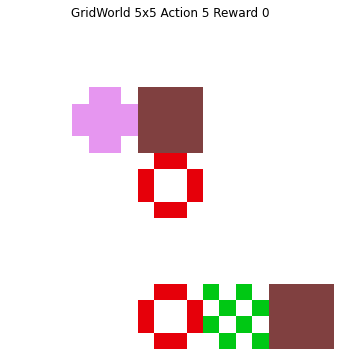

In [3]:
env = stochasticGridWorld(5,5, (1,1),(4,3),"8C",200)
env.addObstacles((4,4),(1,2))
env.addVortex((4,2,0.5), (2,2,0.2))
obs = env.reset()
env.render()

In [4]:
pi = gridPolicy(env)

In [5]:
class AgentGrid(AgentToy):
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
        super().__init__()
    def processObs(self, obs):
        if isinstance(obs, dict):
            return obs["agent"]
        return obs

In [6]:
agent = AgentGrid(env, pi)

In [7]:
agent.test(n_test = 30)

([-39.0,
  -15.0,
  -18.0,
  -23.0,
  -23.0,
  -19.0,
  -32.0,
  -17.0,
  -19.0,
  -26.0,
  -19.0,
  -24.0,
  -15.0,
  -36.0,
  -15.0,
  -24.0,
  -19.0,
  -15.0,
  -18.0,
  -19.0,
  -15.0,
  -15.0,
  -34.0,
  -20.0,
  -19.0,
  -17.0,
  -18.0,
  -17.0,
  -21.0,
  -15.0],
 [25,
  1,
  4,
  9,
  9,
  5,
  18,
  3,
  5,
  12,
  5,
  10,
  1,
  22,
  1,
  10,
  5,
  1,
  4,
  5,
  1,
  1,
  20,
  6,
  5,
  3,
  4,
  3,
  7,
  1])

### Definiendo una politica con comportamiento exploratorio

Se propone elebarorar una nueva polictica que explore, está será de las clases *suaves* o *soft*, en particular $\epsilon - \text{greedy}$. Esto con afán de cumplir las suposiciones que se hace en los algoritmos de aprendizaje sobre una exploración de todos los estados con visitas infinitas. Por practicidad, esta exploración no se lleva al infinito, pero se puede ajustar $\epsilon$ acorde al problemo u observaciones para asegurar de manera empirica la exploración de los estados.

A partir del objeto **gridPolicy**, se expande su comportamiento agregando una epislon.

In [8]:
class gridPolicyEpsilon(gridPolicy):
    def __init__(self, env: Environment, epsilon: float = 0.1):
        assert (epsilon >= 0) and (epsilon <= 1), "Epsilon needs to be a float in [0,1]"
        super(gridPolicyEpsilon, self).__init__(env)
        self.epsilon = epsilon
        self.greedy = False

    def getAction(self, state):
        throw = np.random.uniform()
        if (throw <= self.epsilon) and (not self.greedy):
            action = self.env.actionSpace.sample()
        else:
            if isinstance(state, dict):
                state = state["agent"]
            action = self.pi[state]
        return action

def test(agent:Agent, n:int = 30):
    results , _ = agent.test(n_test = n)
    print("Return: Mean {}, Std {}".format(np.mean(results), np.std(results)))
    return results
    

Se defininen más funciones para el funcionamiento y evaluación  de los algoritmos.

In [29]:
agent = AgentGrid(env, gridPolicyEpsilon(env, epsilon = 0.5))
_ = test(agent)

Return: Mean -30.933333333333334, Std 15.918403046648729


In [30]:
randomAgent = AgentGrid(env, uniformRandomPolicy(env))
_ = test(randomAgent)

Return: Mean -22.133333333333333, Std 8.92835682281771


## Definiendo una función tabular para los valores Q

La intención de este objeto será facilitar en entornos el manejor de una función de valores accion-valor Q. Para esto se utilizarán diccionarios, cuales a partir de un objeto que sea *hashable* se puede mapear una direccion correspondiente a un valor.

In [31]:
class Q_function():
    """
    Action-value function in hashables.
    """

    DEF_ACTION = 5
    AS = None

    def __init__(self, env:Environment = None):
        self.states = dict()
        if env is not None:
            self.AS = env.actionSpace

    def decomposeTuple(self, T):
        state = self.decomposeState(T[0])
        action = self.decomposeAction(T[1])
        return state, action

    @staticmethod
    def decomposeState(S):
        if isinstance(S, dict):
            S = S["agent"]
        if isinstance(S, (int,str,float)):
            return S
        return tuple(S)

    @staticmethod
    def decomposeAction(A):
        if not isinstance(A, int):
            A = int(A)
        return A

    def __getitem__(self, state_action):
        state, action = self.decomposeTuple(state_action)
        fromState = self.states.get(state, dict())
        return fromState.get(action, 0)
    
    def __setitem__(self, state_action, value):
        state, action = self.decomposeTuple(state_action)
        fromState = self.states.get(state)
        if fromState is None:
            self.states[state] = {action:value}
        else:
            action_value = fromState.get(action, 0)
            fromState[action] = value 

    def maxAction(self, state):
        state = self.decomposeState(state)
        actionDict = self.states.get(state,None)
        if actionDict is None:
            return self._defAction()
        maxV = - np.inf
        maxAction = None
        for action in actionDict.keys():
            action_value = actionDict[action]
            if action_value > maxV:
                maxV = action_value
                maxAction = action
        return maxAction

    def getStates(self):
        return self.states.keys()
            
    def _defAction(self):
        if self.AS is None:
            return self.DEF_ACTION
        return self.AS.sample()

## Método Monte-Carlo

In [41]:
def MC(agent:Agent, samples:int = 1, gamma:float = 0.99):
    
    """
    Monte-Carlo state-value function approximation

    parameters
    ----------
    agent: Agent object which contains the policy and the 
        environment
    alpha: float
        Learning rate we want to apply to a running average
    gamma: float [0,1]
        The discount factor we want for the problem's return
    samples: integer > 0
        Number of time we want to samples in the environment of the policy.


    returns
    ------- 
    Q: Q_function
    """

    assert samples > 0, \
        "samples needs to be am integer greater or equal to 1 iteration."
    assert (gamma >= 0) and (gamma <= 1), \
        "Gamma discount factor must be in the interval [0,1]"

    Q = Q_function()
    N = Q_function()
    prosObs = agent.processObs
    env = agent.env
    policy = agent.policy


    agent.testMode(False)
    for i in range(samples):
    # Sample a whole episode
        obs = env.reset()
        done, states, actions, rewards, returns = False, [], [], [], []
        while not done:
            state = prosObs(obs)
            action = policy.getAction(state)
            # Save the states and action seen
            states += [obs]
            actions += [action]
            # Add 1 to the counter for the pair
            N[(obs, action)] = N[(obs, action)] + 1
            # Do the step on the environment
            obs, reward, done = env.step(action)
            rewards += [reward]
            returns += [0.0]

        # After done, calculate the returns
        returns[-1] = rewards[-1]
        for i in range(len(rewards) - 2, -1, -1): # i goes from the top to bottom of the lists
            returns[i] = rewards[i] + gamma * returns[i + 1]

        # Update the value function
        for i in range(len(states)):
            state_action = (states[i], actions[i])
            actualQ = Q[state_action]
            actualN =  1 / N[state_action]
            Q[state_action] = actualQ + actualN * (returns[i] - actualQ)
    return Q
    

In [42]:
Q_MC = MC(agent, samples=10**3)

In [43]:
def VfromQ(env, Q):
    values = np.zeros(env.shape)
    for s in Q.getStates():
        values[s] = Q[(s, Q.maxAction(s))]
    return values

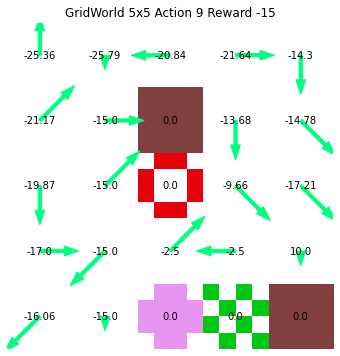

In [44]:
env.render(VfromQ(env, Q_MC), agent.policy)

## Método de diferencias temporales

In [45]:
def TD0(agent:Agent, alpha:float, 
            k:int = 10, gamma:float = 0.99, Q_init = None):
    
    """
    TD 0 state-value function approximation
    
    parameters
    ----------
    agent: Agent object which contains the policy and the 
        environment
    alpha: float > 0
        Learning rate we want to apply to a running average
    k: integer > 0
        Times to iterate the algorithm
    gamma: float [0,1]
        The discount factor we want for the problem's return
    Q_init: Q_Function
        An initial conditions for the value function. If None give, it creates
        a new one filled with zeros

    returns
    ------- 
    Q: Q_function
    """

    assert k > 0, \
        "k needs to be am integer greater or equal to 1 iteration."
    assert (gamma >= 0) and (gamma <= 1), \
        "Gamma discount factor must be in the interval [0,1]"
    assert (alpha > 0), \
        "Alpha must be a float greater than 0"

    Q = Q_function() if Q_init is None else Q_init
    prosObs = agent.processObs
    env = agent.env
    policy = agent.policy

    agent.testMode(False)

    # Do the iterations
    for _ in range(k):
        # Start the environment
        obs = env.reset()
        # get state and first action
        state = prosObs(obs)
        action = policy.getAction(state)
        done = False
        while not done:
            # Execute action A_t
            obs, reward, done = env.step(action)
            # Process action from state s_t+1
            state1 = prosObs(obs)
            action1 = policy.getAction(state1)
            # get value Q from the actual experience
            Q_actual = Q[(state, action)]
            # Calculate the td_error from last value
            # and going to the Q that pi will follow*
            td_error = reward + gamma * Q[(state1,action1)] - Q_actual
            Q[(state, action)] = Q_actual + alpha * td_error
            state, action = state1, action1

    return Q

In [50]:
Q_TD = TD0(agent, 0.1, k = 10**3)

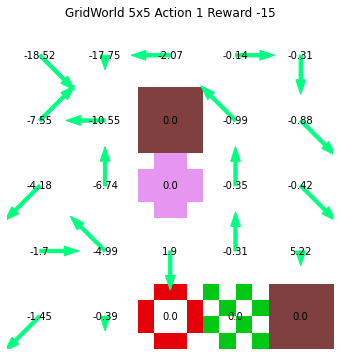

In [51]:
env.render(VfromQ(env, Q_TD), agent.policy)